In [1]:
### addtiional info: https://www.gpxz.io/blog/gpx-file-to-pandas
#### https://towardsdatascience.com/parsing-fitness-tracker-data-with-python-a59e7dc17418

import gpxpy
import gpxpy.gpx
import pandas as pd
import matplotlib.pyplot as plt
# Import seaborn
import seaborn as sns

# Apply the default theme
sns.set_theme()

plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

In [2]:
# Load gpx.
gpx_path = 'Evening_Ride.gpx'
with open('Evening_Ride.gpx', 'r') as gpx_file:
    gpx = gpxpy.parse(gpx_file)

In [3]:
gpx.get_elevation_extremes()

MinimumMaximum(minimum=19.9, maximum=52.0)

In [4]:
# how to pull individual points into an array

gpx.tracks[0].segments[0].points[:10]

[GPXTrackPoint(40.67177, -73.963032, elevation=48.4, time=datetime.datetime(2022, 9, 12, 22, 10, 58, tzinfo=SimpleTZ("Z"))),
 GPXTrackPoint(40.671983, -73.963287, elevation=49.1, time=datetime.datetime(2022, 9, 12, 22, 11, tzinfo=SimpleTZ("Z"))),
 GPXTrackPoint(40.671982, -73.963333, elevation=49.2, time=datetime.datetime(2022, 9, 12, 22, 11, 1, tzinfo=SimpleTZ("Z"))),
 GPXTrackPoint(40.671994, -73.963384, elevation=49.4, time=datetime.datetime(2022, 9, 12, 22, 11, 2, tzinfo=SimpleTZ("Z"))),
 GPXTrackPoint(40.672006, -73.963427, elevation=49.4, time=datetime.datetime(2022, 9, 12, 22, 11, 3, tzinfo=SimpleTZ("Z"))),
 GPXTrackPoint(40.672015, -73.963478, elevation=49.6, time=datetime.datetime(2022, 9, 12, 22, 11, 4, tzinfo=SimpleTZ("Z"))),
 GPXTrackPoint(40.672034, -73.963543, elevation=49.7, time=datetime.datetime(2022, 9, 12, 22, 11, 5, tzinfo=SimpleTZ("Z"))),
 GPXTrackPoint(40.672054, -73.963604, elevation=49.8, time=datetime.datetime(2022, 9, 12, 22, 11, 6, tzinfo=SimpleTZ("Z"))),
 GP

In [5]:
len(gpx.tracks)

1

In [6]:
track = gpx.tracks[0]
track

GPXTrack(name='Evening Ride', segments=[GPXTrackSegment(points=[...])])

In [7]:
track.type

'1'

In [8]:
track.name

'Evening Ride'

In [9]:
track.segments

[GPXTrackSegment(points=[...])]

In [10]:
segment = track.segments[0]
len(segment.points)

2803

In [11]:
random_point = segment.points[44]
random_point

GPXTrackPoint(40.672739, -73.966065, elevation=50.0, time=datetime.datetime(2022, 9, 12, 22, 11, 43, tzinfo=SimpleTZ("Z")))

In [12]:
random_point.extensions

[<Element {http://www.garmin.com/xmlschemas/TrackPointExtension/v1}TrackPointExtension at 0x1d2ac74c240>]

In [13]:
tpe = random_point.extensions[0]
for child in tpe:
    print(child.tag, child.text)

{http://www.garmin.com/xmlschemas/TrackPointExtension/v1}hr 127


In [14]:
segment.get_moving_data()

MovingData(moving_time=2804.0, stopped_time=0.0, moving_distance=23780.637039033547, stopped_distance=0.0, max_speed=10.700970696219994)

In [15]:
from typing import Dict, Union
from datetime import datetime


# The XML namespaces used by the GPX file for extensions, used when parsing the extensions
NAMESPACES = {'garmin_tpe': 'http://www.garmin.com/xmlschemas/TrackPointExtension/v1'}

# The names of the columns we will use in our DataFrame
COLUMN_NAMES = ['latitude', 'longitude', 'elevation', 'time', 'heart_rate', ]

def get_gpx_point_data(point: gpxpy.gpx.GPXTrackPoint) -> Dict[str, Union[float, datetime, int]]:
        """Return a tuple containing some key data about `point`."""
        
        data = {
            'latitude': point.latitude,
            'longitude': point.longitude,
            'elevation': point.elevation,
            'time': point.time
        }
    
        # Parse extensions for heart rate and cadence data, if available
        elem = point.extensions[0]  # Assuming we know there is only one extension
        try:
            data['heart_rate'] = int(elem.find('garmin_tpe:hr', NAMESPACES).text)
        except AttributeError:
            # "text" attribute not found, so data not available
            pass
            

        return data

In [16]:
segment = gpx.tracks[0].segments[0]  # Assuming we know that there is only one track and one segment
data = [get_gpx_point_data(point) for point in segment.points]
df = pd.DataFrame(data, columns=COLUMN_NAMES)

In [17]:
df

,latitude,longitude,elevation,time,heart_rate
0,40.671770,-73.963032,48.4,2022-09-12 22:10:58+00:00,101
1,40.671983,-73.963287,49.1,2022-09-12 22:11:00+00:00,101
2,40.671982,-73.963333,49.2,2022-09-12 22:11:01+00:00,102
3,40.671994,-73.963384,49.4,2022-09-12 22:11:02+00:00,112
4,40.672006,-73.963427,49.4,2022-09-12 22:11:03+00:00,120
...,...,...,...,...,...
2798,40.672500,-73.969643,45.7,2022-09-12 22:57:40+00:00,137
2799,40.672529,-73.969627,45.6,2022-09-12 22:57:41+00:00,136
2800,40.672544,-73.969623,45.4,2022-09-12 22:57:42+00:00,135
2801,40.672544,-73.969623,45.4,2022-09-12 22:57:43+00:00,135


In [18]:
# Most analysis of GPX files involves either the time or distance component. 
# Pandas make it easy to calculate attributes like cumulative distance and time.

import geopy.distance

# Cumulative distance.
coords = [(p.latitude, p.longitude) for p in df.itertuples()]
df['distance'] = [0] + [geopy.distance.distance(from_, to).m for from_, to in zip(coords[:-1], coords[1:])]
df['cumulative_distance'] = df.distance.cumsum()
df['cumulative_miles'] = 0.000621371 * df['cumulative_distance']


# Timing.
df['duration'] = df.time.diff().dt.total_seconds().fillna(0)
df['cumulative_duration'] = df.duration.cumsum()
df['pace_metric'] = pd.Series((df.duration / 60) / (df.distance / 1000)).bfill()

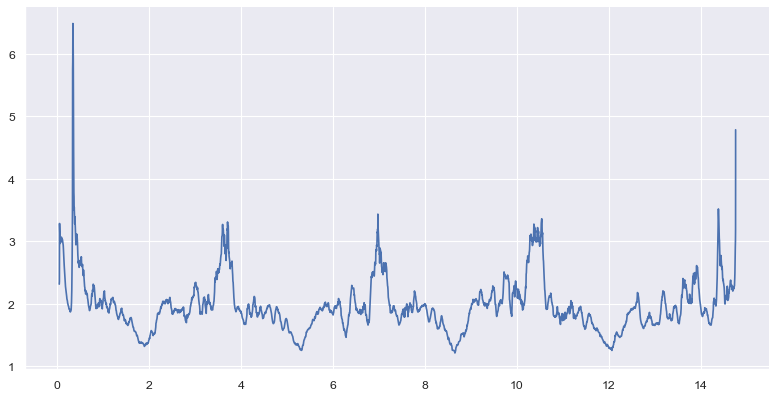

In [19]:
# plot smoothed pace over time

from numpy_ext import rolling_apply
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(12, 6), dpi=80)

def rolling_metric_pace(duration, distance):
    return (duration.sum() / 60) / (distance.sum() / 1000)


x = df.cumulative_miles
y1 = rolling_apply(rolling_metric_pace, 10, df.duration.values, df.distance.values)

plt.plot(x, y1)

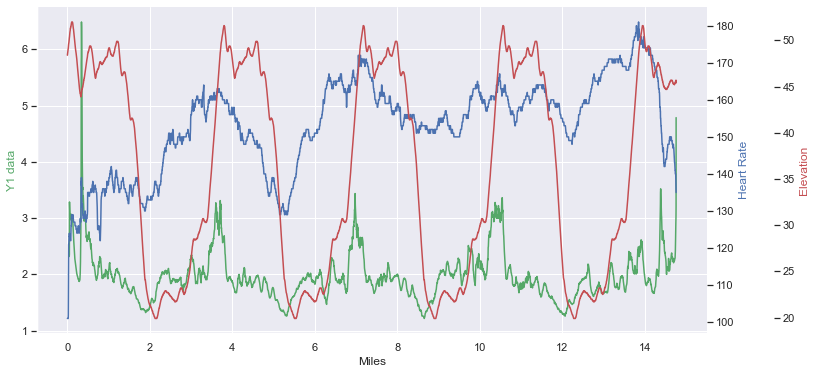

In [20]:
y2 = df.heart_rate
y3 = df.elevation

fig, ax1 = plt.subplots()
fig.set_size_inches(12,6)

ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax3.spines['right'].set_position(("axes", 1.1))

ax1.plot(x, y1, 'g-')
ax2.plot(x, y2, 'b-')
ax3.plot(x, y3, 'r-')

ax1.set_xlabel('Miles')
ax1.set_ylabel('Y1 data', color='g')
ax2.set_ylabel('Heart Rate', color='b')
ax3.set_ylabel('Elevation', color='r')

ax2.grid(False)
ax3.grid(False)

plt.show()

In [21]:
# calculate speed (unnecessary because in data, this is an exercise)
# https://stackoverflow.com/questions/45840118/how-do-i-calculate-speed-from-a-gpx-file-if-the-speed-tag-itself-is-not-given

import numpy as np

# with radius 6371 km as an approximation of the Earth, translate the longitude and latitude into xyz-coordinates:
r = 6371000 # meters
df['theta'] = np.deg2rad(df['longitude'])
df['phi'] = np.deg2rad(df['latitude'])
df['x'] = r*np.cos(df['theta'])*np.sin(df['phi'])
df['y'] = r*np.sin(df['theta'])*np.sin(df['phi'])
df['z'] = r*np.cos(df['phi'])

#  compute distances between consecutive points in meters
df['x2'] = df['x'].shift()
df['y2'] = df['y'].shift()
df['z2'] = df['z'].shift()
df['distancem'] = np.sqrt((df['x2']-df['x'])**2 + (df['y2']-df['y'])**2 + (df['z2']-df['z'])**2)

In [22]:
# So using speed = distance / time:
df['speedm'] = df['distancem'] / 1  # in meters/second
df['speed'] = df['speedm'] * 2.23694 # convert to mph
df['speed']

0             NaN
1       67.199426
2        7.461132
3        8.789838
4        7.582835
          ...    
2798    12.275097
2799     7.665513
2800     3.786975
2801     0.000000
2802     0.000000
Name: speed, Length: 2803, dtype: float64

In [23]:
# the below uses the speed embedded in the data, calling it realspeed

ser = pd.array([0], dtype=float)

for x in range(0,len(df)-1):
    speed = segment.get_speed(x)
    ser = np.append(ser,[speed])

df['realspeedm'] = pd.Series(ser)
df['realspeed'] = df['realspeedm'] * 2.23694 # convert to mph

df['rolling_realspeed'] = df['realspeed'].rolling(10).mean()
df

,latitude,longitude,elevation,time,heart_rate,distance,cumulative_distance,cumulative_miles,duration,cumulative_duration,...,z,x2,y2,z2,distancem,speedm,speed,realspeedm,realspeed,rolling_realspeed
0,40.671770,-73.963032,48.4,2022-09-12 22:10:58+00:00,101,0.000000,0.000000,0.000000,0.0,0.0,...,4.832120e+06,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
1,40.671983,-73.963287,49.1,2022-09-12 22:11:00+00:00,101,32.005101,32.005101,0.019887,2.0,2.0,...,4.832105e+06,1.147060e+06,-3.990553e+06,4.832120e+06,30.040782,30.040782,67.199426,16.017487,35.830156,NaN
2,40.671982,-73.963333,49.2,2022-09-12 22:11:01+00:00,102,3.890927,35.896028,0.022305,1.0,3.0,...,4.832105e+06,1.147047e+06,-3.990575e+06,4.832105e+06,3.335419,3.335419,7.461132,9.952077,22.262198,NaN
3,40.671994,-73.963384,49.4,2022-09-12 22:11:02+00:00,112,4.513304,40.409333,0.025109,1.0,4.0,...,4.832104e+06,1.147043e+06,-3.990576e+06,4.832105e+06,3.929403,3.929403,8.789838,4.199767,9.394626,NaN
4,40.672006,-73.963427,49.4,2022-09-12 22:11:03+00:00,120,3.872205,44.281538,0.027515,1.0,5.0,...,4.832103e+06,1.147040e+06,-3.990578e+06,4.832104e+06,3.389825,3.389825,7.582835,4.190659,9.374252,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2798,40.672500,-73.969643,45.7,2022-09-12 22:57:40+00:00,137,5.494282,23744.318028,14.754031,1.0,2802.0,...,4.832067e+06,1.146614e+06,-3.990740e+06,4.832071e+06,5.487450,5.487450,12.275097,5.447819,12.186444,12.584042
2799,40.672529,-73.969627,45.6,2022-09-12 22:57:41+00:00,136,3.492982,23747.811010,14.756201,1.0,2803.0,...,4.832065e+06,1.146616e+06,-3.990744e+06,4.832067e+06,3.426785,3.426785,7.665513,4.504587,10.076492,12.010034
2800,40.672544,-73.969623,45.4,2022-09-12 22:57:42+00:00,135,1.699701,23749.510711,14.757257,1.0,2804.0,...,4.832064e+06,1.146618e+06,-3.990746e+06,4.832065e+06,1.692926,1.692926,3.786975,2.608120,5.834208,11.064048
2801,40.672544,-73.969623,45.4,2022-09-12 22:57:43+00:00,135,0.000000,23749.510711,14.757257,1.0,2805.0,...,4.832064e+06,1.146618e+06,-3.990747e+06,4.832064e+06,0.000000,0.000000,0.000000,1.715302,3.837028,9.943076


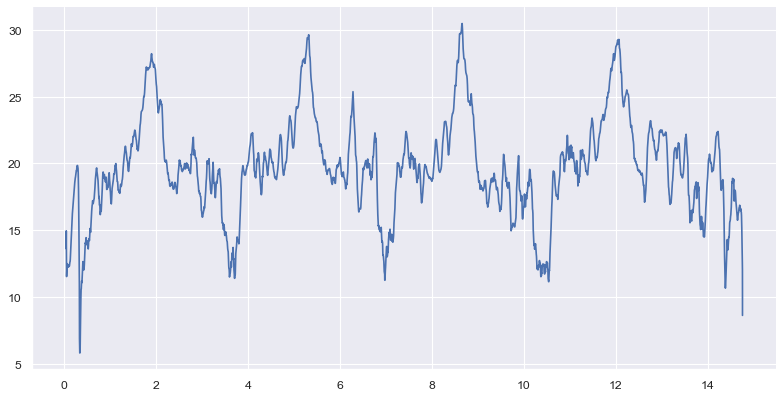

In [24]:
# graph speed

figure(figsize=(12, 6), dpi=80)

x = df.cumulative_miles
y1 = df['rolling_realspeed']

plt.plot(x, y1)

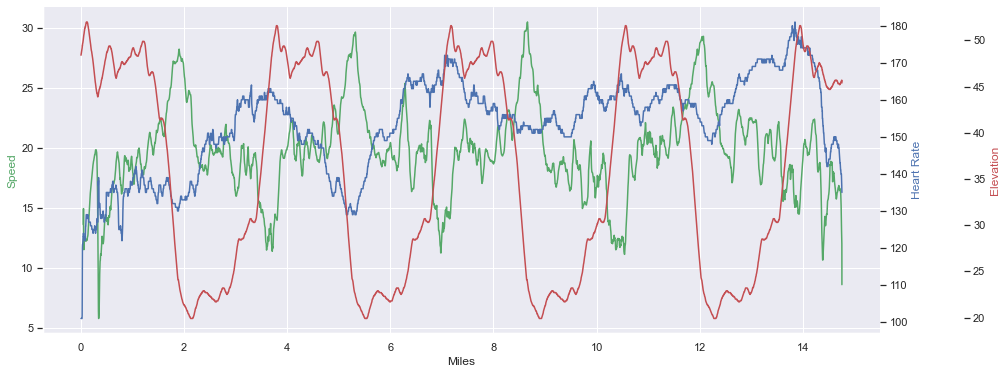

In [25]:
y2 = df.heart_rate
y3 = df.elevation

fig, ax1 = plt.subplots()
fig.set_size_inches(15,6)

ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax3.spines['right'].set_position(("axes", 1.1))

ax1.plot(x, y1, 'g-')
ax2.plot(x, y2, 'b-')
ax3.plot(x, y3, 'r-')

ax1.set_xlabel('Miles')
ax1.set_ylabel('Speed', color='g')
ax2.set_ylabel('Heart Rate', color='b')
ax3.set_ylabel('Elevation', color='r')

ax2.grid(False)
ax3.grid(False)

plt.show()

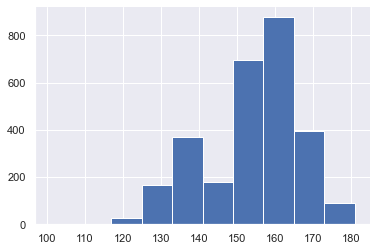

In [26]:
hist = df['heart_rate'].hist(bins=10)

In [27]:
hr_count, division = np.histogram(df['heart_rate'], bins = [0, 109,147,159,170,200])
hr_count = pd.DataFrame(hr_count)
hr_count

,0
0,3
1,644
2,957
3,968
4,231


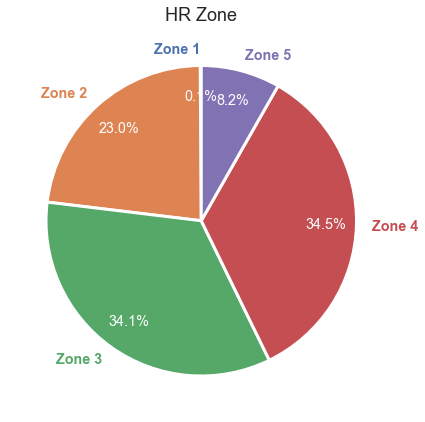

In [36]:
x = hr_count[0]
labels = ['Zone 1', 'Zone 2', 'Zone 3', 'Zone 4', 'Zone 5']

fig, ax = plt.subplots(figsize=(6, 6))

patches, texts, pcts = ax.pie(
    x, labels=labels, pctdistance=0.8, # controls distance from center of %
    autopct='%.1f%%',
    wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
    textprops={'size': 'x-large'},
    startangle=90)
# For each wedge, set the corresponding text label color to the wedge's
# face color.
for i, patch in enumerate(patches):
  texts[i].set_color(patch.get_facecolor())
plt.setp(pcts, color='white')
plt.setp(texts, fontweight=600)
ax.set_title('HR Zone', fontsize=18)

plt.tight_layout()
